In [1]:
import pandas as pd

In [4]:
from sentence_transformers import SentenceTransformer

In [5]:
embed_minilm = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [6]:
usecols = ['news_id','title', 'text']
news = pd.read_csv("/content/filter_data.csv", usecols = usecols)

In [7]:
news.head()

,title,news_id,text
0,What happened to Nex Benedict?,0,What happened to Nex Benedict?. Benedict was a...
1,Supreme Court again refuses to intervene in dr...,1,Supreme Court again refuses to intervene in dr...
2,Oprah Winfrey pays tribute at GLAAD Media Awar...,2,Oprah Winfrey pays tribute at GLAAD Media Awar...
3,"From contradictions to compassion, the LDS Chu...",3,"From contradictions to compassion, the LDS Chu..."
4,"Editor Q&A: Florida can 'say gay,' and what mo...",4,"Editor Q&A: Florida can 'say gay,' and what mo..."


In [8]:
docs = news.text.tolist()

In [9]:
data_embed = embed_minilm.encode(docs)

In [10]:
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
k = 10 # k is currently fixed at 10
kmeans = KMeans(n_clusters=k, random_state=42, n_init = 'auto')
y_pred = kmeans.fit_predict(data_embed)
news['cluster'] = y_pred

In [20]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=50)  # Changed perplexity from 100 to 50 per FAQ
X_embedded = tsne.fit_transform(data_embed)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 370 samples in 0.001s...
[t-SNE] Computed neighbors for 370 samples in 0.067s...
[t-SNE] Computed conditional probabilities for sample 370 / 370
[t-SNE] Mean sigma: 0.362747
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.403065
[t-SNE] KL divergence after 1000 iterations: 0.903431


In [25]:
X_embedded.shape

(370, 2)

<ipython-input-23-6f5ad02488e6>:12: UserWarning: The palette list has more values (20) than needed (10), which may not be intended.
  sns.scatterplot(x= X_embedded[:,0], y = X_embedded[:,1], hue=y_pred, legend='full', palette=palette)


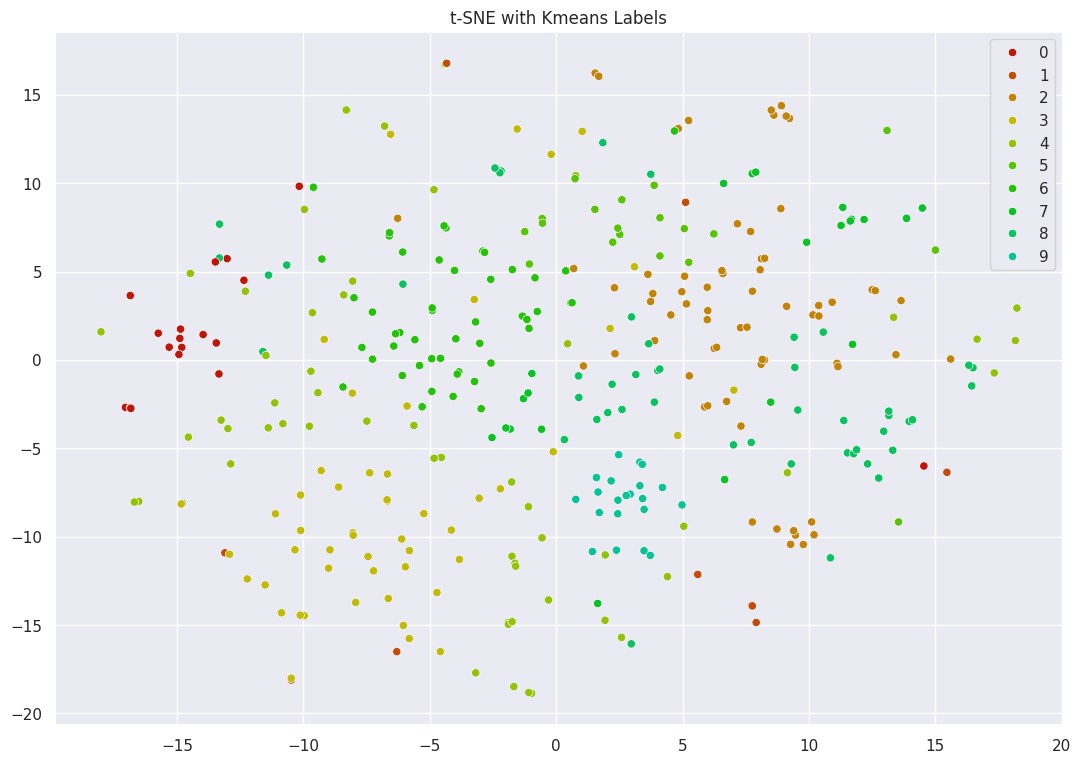

In [23]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(20, l=.1, s=.9)

# plot
sns.scatterplot(x= X_embedded[:,0], y = X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

In [12]:
news.head()

,title,news_id,text,cluster
0,What happened to Nex Benedict?,0,What happened to Nex Benedict?. Benedict was a...,0
1,Supreme Court again refuses to intervene in dr...,1,Supreme Court again refuses to intervene in dr...,6
2,Oprah Winfrey pays tribute at GLAAD Media Awar...,2,Oprah Winfrey pays tribute at GLAAD Media Awar...,4
3,"From contradictions to compassion, the LDS Chu...",3,"From contradictions to compassion, the LDS Chu...",5
4,"Editor Q&A: Florida can 'say gay,' and what mo...",4,"Editor Q&A: Florida can 'say gay,' and what mo...",2


In [27]:
X_embedded[0:3]

array([[-14.886755 ,   1.2184441],
       [-14.788931 ,  -8.117183 ],
       [-12.984646 ,  -3.8863063]], dtype=float32)

In [29]:
news_pos = pd.DataFrame(X_embedded, columns = ['x_pos', 'y_pos'])

In [30]:
news_pos

,x_pos,y_pos
0,-14.886755,1.218444
1,-14.788931,-8.117183
2,-12.984646,-3.886306
3,6.237905,7.129940
4,7.292744,1.820129
...,...,...
365,1.030088,12.930396
366,-2.207606,-7.296374
367,17.333069,-0.736543
368,9.149118,-6.382521


In [36]:
news_cluster = pd.concat([news, news_pos], axis = 1)

In [37]:
news_cluster.cluster.value_counts()

cluster
2    68
4    56
6    52
3    52
8    49
7    23
5    21
9    21
0    18
1    10
Name: count, dtype: int64

In [38]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
import string
from tqdm import tqdm

In [39]:
parser = en_core_web_sm.load()

In [40]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)

custom_stop_words = ["lgbt", 'lgbtq', 'woman', 'queer', 'people', 'gay', 'article', 'com', 'read']

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

In [41]:
def spacy_tokenizer(sentence):
    mytokens = parser(str(sentence))
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations]
    mytokens = [ word for word in mytokens if len(word) > 3]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [42]:
tqdm.pandas()
news["processed_text"] = news["text"].progress_apply(spacy_tokenizer)

100%|██████████| 370/370 [00:05<00:00, 64.59it/s]


In [43]:
news = news[~news['processed_text'].str.contains("removed")]
news = news[news['processed_text'] != 'nan']

In [44]:
vectorizers = []
for ii in range(0, 10):
    # Creating a vectorizer for each cluster
    vectorizers.append(CountVectorizer(min_df=2, max_df=0.9,
                                       stop_words=stopwords, lowercase=True,
                                       token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [45]:
vectorized_data = []
for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(news.loc[news['cluster'] == current_cluster, 'processed_text']))
    except Exception as e:
        vectorized_data.append(None)

In [46]:
vectorized_data[0]

<18x44 sparse matrix of type '<class 'numpy.int64'>'
	with 133 stored elements in Compressed Sparse Row format>

In [47]:
num_topics_per_cluster = 2
lda_models = []
for ii in range(0, 10):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=num_topics_per_cluster, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)

In [48]:
clusters_lda_data = []
for current_cluster, lda in enumerate(lda_models):
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

In [49]:
# Selecting keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []

    for _, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names_out()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])

    keywords.sort(key = lambda x: x[1])
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [50]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))
    else:
        all_keywords.append([])

In [51]:
cluster_represent_doc = pd.DataFrame(columns = ['cluster_no', 'news_id', 'news_title'])

In [52]:
def get_represent_docs(cluster_no):
    news_df = news[news.cluster == cluster_no]
    lda_model = lda_models[cluster_no]
    document_topic_distributions = lda_model.fit_transform(vectorized_data[cluster_no])

    num_top_documents = 2  # Number of top documents to retrieve for each topic
    representative_docs_per_topic = []

    for topic_idx in range(lda_model.n_components):
        top_document_indices = sorted(range(len(document_topic_distributions)),
                                    key=lambda i: document_topic_distributions[i][topic_idx],
                                    reverse=True)[:num_top_documents]

        top_documents = [news_df.iloc[i]['news_id'] for i in top_document_indices]
        representative_docs_per_topic.append(top_documents)
    l = [item for sublist in representative_docs_per_topic for item in sublist]
    return ','.join([str(i) for i in l])

In [53]:
get_represent_docs(0)

'36,25,100,102'

In [54]:
cluster_keywords = pd.DataFrame(columns = ['cluster', 'keywords', 'repre_news'])
for cluster, keywords in enumerate(all_keywords):
    kw_str = ', '.join(keywords)
    repre_docs = get_represent_docs(cluster)
    new_row = {'cluster': cluster, 'keywords': kw_str, 'repre_news': repre_docs}
    cluster_keywords.loc[len(cluster_keywords)] = new_row

cluster_keywords.to_csv("/cluster_keywords.csv")

In [55]:
news_cluster['news_id'] = news_cluster['news_id'].astype('int')
news_cluster = news_cluster.sort_values(by = 'news_id')

news_cluster.to_csv("/news_cluster.csv")

In [56]:
with open('/cluster_keywords.txt', 'a') as f:
    pd.set_option('display.max_colwidth', None)
    dfAsString = cluster_keywords.keywords.to_string(header=False, index=False)
    f.write(dfAsString)

In [57]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [58]:
cluster_keywords

,cluster,keywords,repre_news
0,0,"benedict, death, charge, student, college, strain","36,25,100,102"
1,1,"eurovision, boycott, growth, gaza, israel, song","192,172,274,21"
2,2,"bill, anti, state, book, report, school","152,151,324,122"
3,3,"star, film, transgender, glaad, love","22,20,366,7"
4,4,"trump, year, donald, host, health, face","63,177,230,83"
5,5,"transgender, city, sanctuary, identify, lesbian, orgasm","154,156,329,34"
6,6,"transgender, sport, athlete, court, ncaa, lawsuit","235,234,81,160"
7,7,"gender, vatican, surrogacy, change, james","296,299,50,358"
8,8,"russia, anti, face, arrest, trans, tran","166,252,260,289"
9,9,"transgender, visibility, biden, trump, president","210,216,262,317"


In [59]:
news_cluster.head()

,title,news_id,text,cluster,processed_text,x_pos,y_pos
0,What happened to Nex Benedict?,0,"What happened to Nex Benedict?. Benedict was attacked at their Oklahoma high school, and found dead at home the next day. The medical examiner's office says the nonbinary 16-year-old died by suicide. Their family has questions.",0,happen benedict benedict attack oklahoma high school find dead home medical examiner office nonbinary year suicide family question,-14.886755,1.218444
1,Supreme Court again refuses to intervene in drag show controversy,1,Supreme Court again refuses to intervene in drag show controversy. It was the second time the court has refused to step into a drag controversy this term.,6,supreme court refuse intervene drag controversy second time court refuse step drag controversy term,-14.788931,-8.117183
2,Oprah Winfrey pays tribute at GLAAD Media Awards to gay brother who died from AIDS,2,"Oprah Winfrey pays tribute at GLAAD Media Awards to gay brother who died from AIDS. In an emotional speech during the GLAAD Media Awards in Los Angeles Thursday night, Oprah Winfrey paid a tearful tribute to her late brother, Jeffrey Lee, who died from AIDS in 1989 when he was just 29 years old.",4,oprah winfrey tribute glaad media awards brother aids emotional speech glaad media awards angeles thursday night oprah winfrey tearful tribute late brother jeffrey aids 1989 year,-12.984646,-3.886306
3,"From contradictions to compassion, the LDS Church struggles with LGBTQ+ inclusion",3,"From contradictions to compassion, the LDS Church struggles with LGBTQ+ inclusion. Despite assertions of immutability and consistency, The Church of Jesus Christ of Latter-day Saints’s positions on sexuality and gender have proven fragile and changeable across time. Throughout much of the 19th century, for example, plural marriage between a…",5,contradiction compassion church struggle lgbtq+ inclusion despite assertion immutability consistency church jesus christ saints position sexuality gender prove fragile changeable time 19th century example plural marriage,6.237905,7.129940
4,"Editor Q&A: Florida can 'say gay,' and what motivates LGBTQ+ voters",4,"Editor Q&A: Florida can 'say gay,' and what motivates LGBTQ+ voters. It was a busy week in LGBTQ+ news, and two Advocate editors sat down for a conversation about the latest headlines on Advocate Today. Up for discussion: a settlement on the ‘don't say gay’ bill in Florida, and a new poll that found restrictions on trans and a…",2,editor florida motivate lgbtq+ voter busy week lgbtq+ news advocate editor conversation late headline advocate today discussion settlement bill florida poll find restriction tran,7.292744,1.820129


In [60]:
news_cluster.value_counts('cluster')

cluster
2    68
4    56
3    52
6    52
8    49
7    23
5    21
9    21
0    18
1    10
Name: count, dtype: int64